<a href="https://colab.research.google.com/github/bayashi-cl/statistical-learning/blob/main/note/03_LinearRegression_appendix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U mlxtend

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mlxtend.regressor import LinearRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols

sns.set()

# 最小二乗推定に関する補足

最小二乗推定量 $\hat{\beta}$ は正規方程式を利用して次のように求めていた。

$$\hat{\beta} = (X^\top X)^{-1}X^\top y$$

しかし、この方法ではいくつかの問題点が存在する。
* $X$ が正則でない場合に $\hat{\beta}$ を求めることができない
* パラメーターが増えると計算が遅くなる。

これらの問題に対処するためのいくつかの手法を示す。

In [ ]:
ad = pd.read_csv("https://www.statlearning.com/s/Advertising.csv", index_col=0)

In [ ]:
ad["TV2"] = ad["TV"] * 2
ad.head()

## 多重共線性への対処
### 0. Xが正則の場合：QR分解

$A$ が行、または列でフルランクの場合 $A=QR$ と分解できる。ここで、 $Q$ は直交行列であり、 $R$ は上三角行列である。よって、最小二乗推定量は

$$\hat{\beta} = R^{-1}Q^\top y$$

で求められる。

In [ ]:
try:
  model_qr = ols(formula='sales ~ newspaper + radio + TV + TV2', data=ad).fit(method="qr")
  print(model_qr.summary2())
except np.linalg.LinAlgError as e:
  print("ERROR!!")
  print(e)

### 1. $X$ が正則でない場合：特異値分解(SVD)

$X$ の**Moore-Penrose一般逆行列**（擬似逆行列）$X^+$ を以下の条件を満たす行列と定義する。
1. $XX^+X = X$
1. $X^+XX^+=X$
1. $(X^+X)^\top = X^+X$
1. $(XX^+)^\top = XX^+$

任意の行列 $A$ は $A = U\Sigma V^\top$ と分解できる、ただし、 $U,V$ は
直交行列、 $\Sigma$ は $A$ の特異値からなる対角行列である。

また、 $A^+$ は $A^+ = U\Sigma^+V$ と分解でき、 $\Sigma^+$ は特異値の逆数からなる対角行列になる。

この行列による最小二乗推定量は

$$\hat\beta = X^+y$$

となり、(L2)ノルムを最小化する(->Ridge回帰と同じ?)。この方法はQR分解より非効率的である。

In [ ]:
model_svd = ols(formula='sales ~ newspaper + radio + TV + TV2', data=ad).fit(method="pinv")
print(model_svd.summary2())

## 計算量の問題

逆行列を求めるにあたって余因子展開を用いるなら $O(p!)$ QR分解を用いるなら $O(p^3)$ の時間計算量がかかり、変数が増えるとともに計算により長い時間が必要になる。

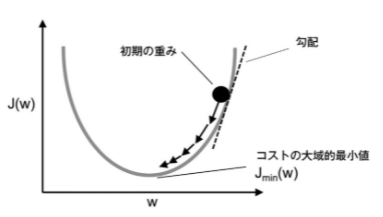

### （確率的）勾配降下法

勾配降下法は線形回帰だけでなく広くコスト関数の大域的最小値を求めるために使われる。

"勾配にそってコスト関数を下る"という操作を繰り返し最適解に近づける。

OLSの場合、コスト関数を$J$, パラメータを$w$, $i$番目のデータ$j$番目の説明変数を $x^{(i)}_j$として

$$J(w)=\frac{1}{2}\sum_i\left(y^{(i)}-\hat{y}^{(i)}\right)^2$$

パラメータの更新は

$$w := w + \Delta w$$
$$\Delta w = -\eta\nabla J(w)$$

ここで、 $\nabla J(w)$ はコスト関数の**勾配**で説明変数ごとにコスト関数を偏微分することで得られる。

$$
\begin{aligned}
  \frac{\partial J}{\partial w_j} &= \frac{1}{2}\frac{\partial J}{\partial w_j}\sum_i\left(y^{(i)}-\hat{y}^{(i)}\right)^2\\
  &= \frac{1}{2}\sum_i2\left(y^{(i)}-\hat{y}^{(i)}\right)\frac{\partial J}{\partial w_j}\left(y^{(i)}-\sum_k(w_kx^{(i)}_k)\right)\\
  &= -\sum_i\left(y^{(i)}-\hat{y}^{(i)}\right)x^{(i)}_j
\end{aligned}
$$


また、 $\eta$ は**学習率**でどれだけの距離を移動するかを定める。値が大きいと収束しないことがあるが、小さすぎると収束に時間がかかる。

 # Exploring the Housing dataset
 ## Loading the Housing dataset into a data frame
 Description, which was previously available at: [https://archive.ics.uci.edu/ml/datasets/Housing](https://archive.ics.uci.edu/ml/datasets/Housing)

Attributes:
    
```
1. CRIM      per capita crime rate by town
2. ZN        proportion of residential land zoned for lots over 
                 25,000 sq.ft.
3. INDUS     proportion of non-retail business acres per town
4. CHAS      Charles River dummy variable (= 1 if tract bounds 
                 river; 0 otherwise)
5. NOX       nitric oxides concentration (parts per 10 million)
6. RM        average number of rooms per dwelling
7. AGE       proportion of owner-occupied units built prior to 1940
8. DIS       weighted distances to five Boston employment centres
9. RAD       index of accessibility to radial highways
10. TAX      full-value property-tax rate per $10,000
11. PTRATIO  pupil-teacher ratio by town
12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks 
                 by town
13. LSTAT    % lower status of the population
14. MEDV     Median value of owner-occupied homes in $1000s
```

In [ ]:
# データの取得
df = pd.read_csv('https://raw.githubusercontent.com/rasbt/'
                 'python-machine-learning-book-3rd-edition/'
                 'master/ch10/housing.data.txt',
                 header=None,
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

In [ ]:
# 標準化
X = df[['RM']].values
y = df['MEDV'].values
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

In [ ]:
class LinearRegressionGD(object):

  def __init__(self, eta=0.001, n_iter=20):
    self.eta = eta
    self.n_iter = n_iter

  def fit(self, X, y, init_w=None):
    if init_w is None:
      self.w_ = np.zeros(1 + X.shape[1])
    else:
      self.w_ = np.array(init_w)
    self.cost_ = []
    self.history = np.zeros((self.n_iter, 1 + X.shape[1]))

    for i in range(self.n_iter):
      self.history[i] = self.w_[:]
      output = self.net_input(X)
      errors = (y - output)
      self.w_[1:] += self.eta * X.T.dot(errors)
      self.w_[0] += self.eta * errors.sum()
      cost = (errors**2).sum() / 2.0
      self.cost_.append(cost)
    return self

  def net_input(self, X):
    return np.dot(X, self.w_[1:]) + self.w_[0]

  def predict(self, X):
    return self.net_input(X)

In [ ]:
# 学習
lr = LinearRegressionGD(eta=0.003)
lr.fit(X_std, y_std, (0.75, 0.2))

In [ ]:
# QR分解でも学習
qr_lr = LinearRegression(method='qr')
qr_lr.fit(X_std, y_std)

In [ ]:
# プロット
plt.scatter(X_std.T, y_std)
plt.plot(X_std, lr.predict(X_std), color="red", label="gd")
plt.plot(X_std, qr_lr.predict(X_std), color="green", label="qr", alpha=0.5)
plt.xlabel("RM")
plt.ylabel("MEDV")
plt.legend()
plt.show()

In [ ]:
# 等高線用のRSS
sz = 50
b0_ = np.linspace(lr.w_[0] - 1, lr.w_[0] + 1, sz)
b1_ = np.linspace(lr.w_[1] - 1, lr.w_[1] + 1, sz)
b0, b1 = np.meshgrid(b0_, b1_, indexing='xy')
rss = np.zeros((sz, sz))

for (i, j), _ in np.ndenumerate(rss):
    rss[i, j] = ((y_std - (b0[i, j] + X_std.T * b1[i, j]))**2).sum() / 2.0

In [ ]:
fig, ax = plt.subplots()
# 等高線
cont = ax.contour(b0, b1, rss, cmap=plt.cm.Set1)
cont.clabel(fmt='%1.0f', fontsize=10)
# 学習結果
ax.scatter(lr.w_[0], lr.w_[1], label=r"$\hat{w}$", color="red", s=100)
# 学習過程
plt.plot(lr.history.T[0], lr.history.T[1], marker="o", markersize=5, alpha=0.6)

ax.set(xlabel=r"intercept", ylabel=r"slope", title="RSS")
ax.legend()
plt.show()

## 各ライブラリで利用可能な手法

|言語|ライブラリ|||
|:-:|:-:|:--|:--|
|R     |stats::lm|QR分解|[リンク](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/lm.html)|
|Python|statsmodels.regression.linear_model.OLS|擬似逆行列/qr分解|[リンク](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.fit.html#statsmodels.regression.linear_model.OLS.fit)|
|Python|mlxtend.regressor.LinearRegression|閉形式/QR分解/特異値分解/勾配降下法/確率的勾配降下法|[リンク](http://rasbt.github.io/mlxtend/user_guide/regressor/LinearRegression/)|
|Python|sklearn.linear_model.LinearRegression|不明(xGELSD?)|[リンク](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)|

### 参考
* ［第3版］Python機械学習プログラミング 達人データサイエンティストによる理論と実践
ISBN: 978-4295010074
* データ分析基礎線形代数の基礎知識 (増強版)
[リンク](http://ds.k.kyoto-u.ac.jp/e-learning_files/data_analysis_basic/slide-03a.pdf)
* mlxtend User Guide LinearRegression
[リンク](https://rasbt.github.io/mlxtend/user_guide/regressor/LinearRegression/)
* 【解説】 一般逆行列
[リンク](https://www.slideshare.net/wosugi/ss-79624897)